# Pytorch MNIST手書き数字の分類 - RNNネットワーク -

- RNNで構築したネットワークの実装を行い、MNIST分類を学習し推論します。

# 事前準備

## モジュールインポート

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## GPUとCPUの自動判別

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cpu


# Datasetの準備

## MNISTデータセット

In [3]:
#データ前処理 transform を設定
transform = transforms.Compose(
    [transforms.ToTensor(),                      # Tensor変換とshape変換 [H, W, C] -> [C, H, W]
     transforms.Normalize((0.5, ), (0.5, ))])    # 標準化 平均:0.5  標準偏差:0.5


#訓練用(train + validation)のデータセット サイズ:(channel, height, width) = (1,28,28) 60000枚
trainval_dataset = datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

#訓練用ータセットを train と val にshuffleして分割する
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [40000, 20000])

print("train_dataset size = {}".format(len(train_dataset)))
print("val_dataset size = {}".format(len(val_dataset)))

#テスト(test)用のデータセット サイズ:(channel, height, width) = (1,28,28) 10000枚
test_dataset = datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)

train_dataset size = 40000
val_dataset size = 20000


# Detaloaderの作成

In [4]:
#訓練用 Dataloder
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=64,
                                            shuffle=True)
#検証用 Dataloder
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=64,
                                            shuffle=False)

#テスト用 Dataloder
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size=64,
                                            shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

## 動作の確認

imges size =  torch.Size([64, 1, 28, 28])
labels size =  torch.Size([64])


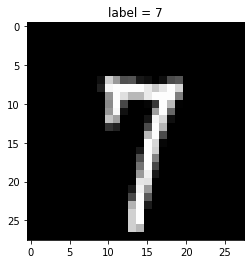

In [5]:
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す
print("imges size = ", imges.size())
print("labels size = ", labels.size())

#試しに1枚 plot してみる
plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.title("label = {}".format(labels[0].numpy()))
plt.show()

# ネットワークモデルの作成
- RNNのモデル

In [6]:
class Net(nn.Module):

    def __init__(self):
        
        super(Net, self).__init__()
        self.seq_len = 28              # 画像の Height を時系列のSequenceとしてRNNに入力する
        self.feature_size = 28         # 画像の Width を特徴量の次元としてRNNに入力する
        self.hidden_layer_size = 128   # 隠れ層のサイズ
        self.rnn_layers = 1            # RNNのレイヤー数　(RNNを何層重ねるか)
        
        self.simple_rnn = nn.RNN(input_size = self.feature_size,
                                 hidden_size = self.hidden_layer_size,
                                 num_layers = self.rnn_layers) 

        self.fc = nn.Linear(self.hidden_layer_size, 10)
        
    def init_hidden(self, batch_size): # RNNの隠れ層 hidden を初期化
        hedden = torch.zeros(self.rnn_layers, batch_size, self.hidden_layer_size)
        return hedden

    def forward(self, x):
        batch_size = x.shape[0]
        
        self.hidden = self.init_hidden(batch_size)
        
        x = x.view(batch_size, self.seq_len, self.feature_size)  # (Batch, Cannel, Height, Width) -> (Batch, Height, Width) = (Batch, Seqence, Feature)
                                                                 # 画像の Height を時系列のSequenceに、Width を特徴量の次元としてRNNに入力する
        x = x.permute(1, 0, 2)                                   # (Batch, Seqence, Feature) -> (Seqence , Batch, Feature)
        
        rnn_out, h_n = self.simple_rnn(x, self.hidden)           # RNNの入力データのShapeは(Seqence, Batch, Feature)
                                                                 # (h_n) のShapeは (num_layers, batch, hidden_size)
        x = h_n[-1,:,:]                                          # RNN_layersの最後のレイヤーを取り出す (l, B, h)-> (B, h)
        x = self.fc(x)
        
        return x

In [7]:
#モデル作成
net = Net().to(device)   # GPUを使用する場合のために明示的に .to(device) を指定

In [8]:
#ネットワークのレイヤー確認
print(net)

Net(
  (simple_rnn): RNN(28, 128)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


# 損失関数の定義

In [9]:
# nn.CrossEntropyLoss() はソフトマックス関数＋クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()

# 最適化手法の設定

In [10]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 学習・検証の実施

In [11]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for i , (inputs, labels) in tqdm(enumerate(dataloaders_dict[phase])):
                
                # GPUを使用する場合は明示的に指定
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):  # 訓練モードのみ勾配を算出
                    outputs = net(inputs)              # 順伝播
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [12]:
# 学習・検証を実行する
num_epochs = 3
train_model(net, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)

6it [00:00, 59.01it/s]

Epoch 1/3
-------------


313it [00:04, 68.84it/s]
4it [00:00, 34.06it/s]

val Loss: 2.3301 Acc: 0.0954
Epoch 2/3
-------------


625it [00:12, 50.79it/s]
8it [00:00, 71.97it/s]

train Loss: 0.9101 Acc: 0.6890


313it [00:04, 72.83it/s]
6it [00:00, 53.88it/s]

val Loss: 0.5833 Acc: 0.8081
Epoch 3/3
-------------


625it [00:12, 50.88it/s]
7it [00:00, 67.33it/s]

train Loss: 0.4456 Acc: 0.8674


313it [00:04, 69.69it/s]

val Loss: 0.4203 Acc: 0.8796


# テストデータに対する予測

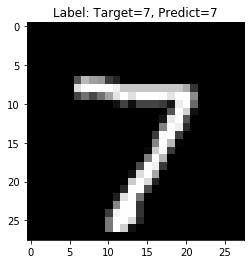

In [13]:
batch_iterator = iter(dataloaders_dict["test"])  # イテレータに変換
imges, labels = next(batch_iterator)  # 1番目の要素を取り出す

net.eval() #推論モード
with torch.set_grad_enabled(False):   # 推論モードでは勾配を算出しない
    outputs = net(imges)               # 順伝播
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    
#テストデータの予測結果を描画
plt.imshow(imges[0].numpy().reshape(28,28), cmap='gray')
plt.title("Label: Target={}, Predict={}".format(labels[0], preds[0].numpy()))
plt.show()

以上